# 1. Import the dataset and the libraries:

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score

%matplotlib inline


In [2]:
data = pd.read_csv("data/framingham.csv")
data.head(2)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0


## 2. Perform exploratory data analysis:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


Education is irrelevant feature, so we will drop it.

In [4]:
data.drop(['education'], inplace=True, axis=1)

Now, we will check the null-values:

In [5]:
data.isna().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

The dataset is big, so for now, we will drop the null values:

In [6]:
data.dropna(inplace=True, axis=0)
data.isna().sum()

male               0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

### Univariate Analysis:

#### Histogram:

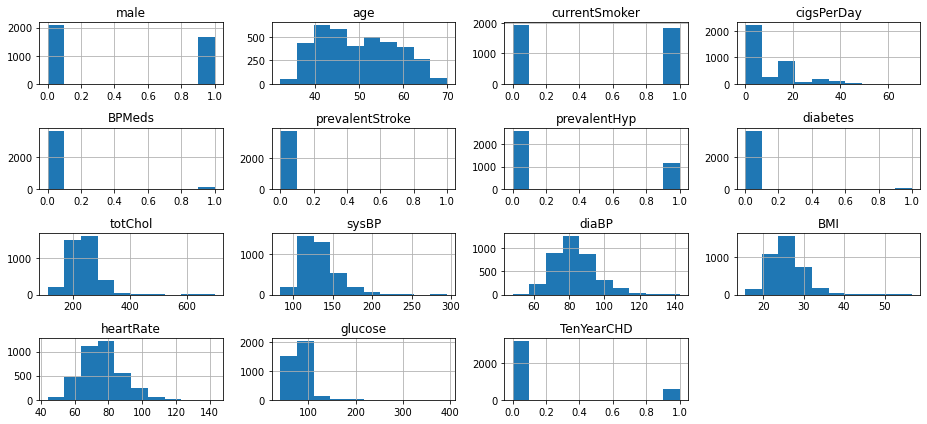

In [7]:
data.hist(figsize=(13, 6), sharey=False)
plt.tight_layout()
plt.show()

#### Density Plot:

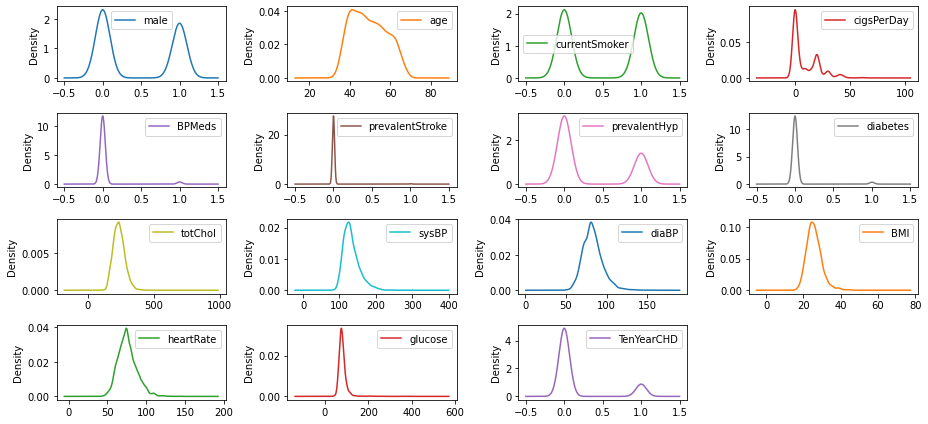

In [8]:
data.plot(kind='kde', subplots=True, layout=(4, 4), figsize=(13, 6), sharex=False)
plt.tight_layout()
plt.show()

#### Box-Plot:

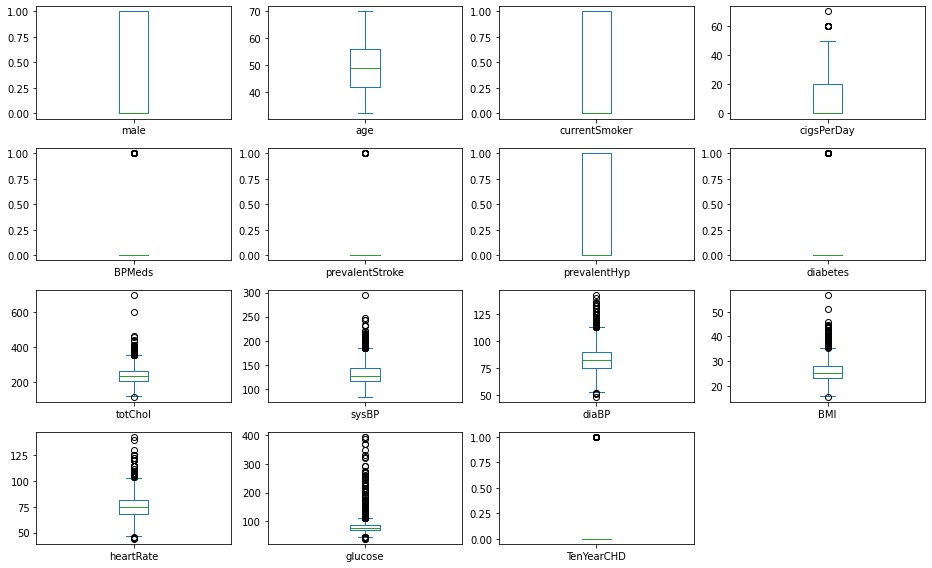

In [9]:
data.plot(kind='box', subplots=True, layout=(4, 4), figsize=(13, 8), sharex=False)
plt.tight_layout()
plt.show()

### Multivariate Analysis:

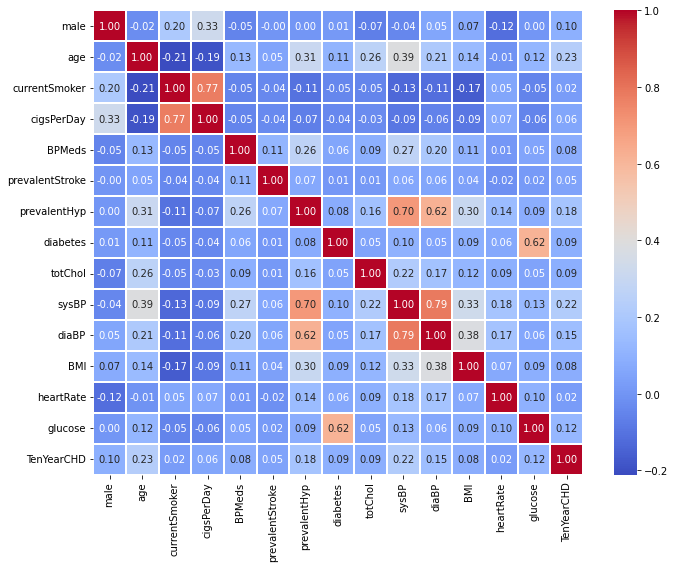

In [10]:
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.4, cmap='coolwarm')
plt.tight_layout()
plt.show()

Check the class count:

In [11]:
data['TenYearCHD'].value_counts()

TenYearCHD
0    3179
1     572
Name: count, dtype: int64

**There is a class imbalance here.**

We will oversample the minority class, train with both the original and these oversampled class to see the difference in the accuracy later on.

#### Separating the majority and minroity class:

In [12]:
majority = data[data['TenYearCHD'] == 0]
minorty = data[data['TenYearCHD'] == 1]

#### Oversampling the minority class:

In [13]:
minority_oversampled = resample(minorty, replace=True, n_samples=len(majority), random_state=42)
minority_oversampled['TenYearCHD'].value_counts()

TenYearCHD
1    3179
Name: count, dtype: int64

#### Concat the oversampled and majority class:

In [14]:
oversampled_data = pd.concat([majority, minority_oversampled])
oversampled_data.shape

(6358, 15)

In [15]:
oversampled_data['TenYearCHD'].value_counts()

TenYearCHD
0    3179
1    3179
Name: count, dtype: int64

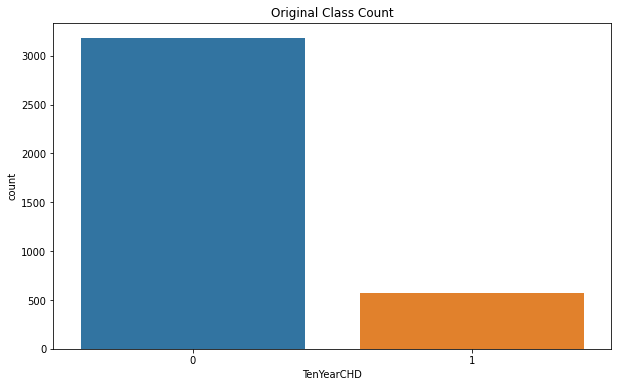

In [16]:
custom_colors = ["#1f77b4", "#ff7f0e"] 

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='TenYearCHD', palette=custom_colors, legend=False, hue='TenYearCHD')
plt.title("Original Class Count")
plt.show()

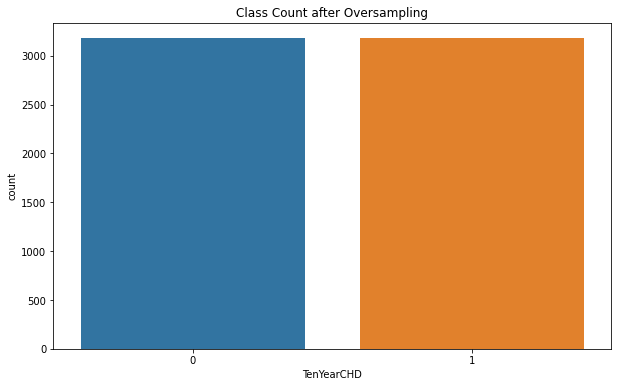

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=oversampled_data, x='TenYearCHD', palette=custom_colors, legend=False, hue='TenYearCHD')
plt.title("Class Count after Oversampling")
plt.show()

## 3. Feature Engineering:

### Original Data:

#### 3.1 Split the data into training and testing data:

In [18]:
data.head(1)

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0


In [19]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)


In [20]:
print(X_train.shape, y_train.shape)

(2513, 14) (2513,)


In [21]:
print(X_test.shape, y_test.shape)

(1238, 14) (1238,)


#### 3.2 Pipeline:

Now, we will use **Pipeline** so that the following pre-processing steps are consistently applied to both the training and testing data without data leakage.

**Here, we will use Pipeline to do 3 major steps:**
1. Implement SelectKBest to pull 7 best features.
2. Use StandarScaler to transform the data.
3. Finally, train the LogisticRegression() model.

In [22]:
pipeline = Pipeline([
    ('selectKbest', SelectKBest(score_func=chi2, k=7)),
    ('standardScaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=3000))
])

In [23]:
# Fitting the pipeline to the training data:

pipeline.fit(X_train, y_train)

Pipeline(steps=[('selectKbest',
                 SelectKBest(k=7,
                             score_func=<function chi2 at 0x0000020C78884D30>)),
                ('standardScaler', StandardScaler()),
                ('log_reg', LogisticRegression(max_iter=3000))])

In [24]:
# Making the prediction:
y_train_predict = pipeline.predict(X_train)
y_test_predict = pipeline.predict(X_test)

#### Since we have a class imbalance problem, accuracy is not a good metrics to use for the conclusion.

In [25]:
# Printing the accuracy:
print(f"Training Accuracy: {accuracy_score(y_train, y_train_predict) * 100:.2f}%.")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_predict) * 100:.2f}%.")
print("\n")


# Printing the precision:
print(f"Training Precision: {precision_score(y_train, y_train_predict) * 100:.2f}%.")
print(f"Testing Precision: {precision_score(y_test, y_test_predict) * 100:.2f}%.")
print("\n")

# Printing the Recall:
print(f"Training Recall: {recall_score(y_train, y_train_predict) * 100:.2f}%.")
print(f"Testing Recall: {recall_score(y_test, y_test_predict) * 100:.2f}%.")
print("\n")

# Printing the F1-Score:
print(f"Training F1-Score: {f1_score(y_train, y_train_predict) * 100:.2f}%.")
print(f"Testing F1-Score: {f1_score(y_test, y_test_predict) * 100:.2f}%.")

Training Accuracy: 85.48%.
Testing Accuracy: 85.14%.


Training Precision: 75.00%.
Testing Precision: 53.85%.


Training Recall: 8.53%.
Testing Recall: 3.78%.


Training F1-Score: 15.31%.
Testing F1-Score: 7.07%.


### Over sample data:

In [32]:
oversampled_data.head(1)

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0


In [33]:
X_over = oversampled_data.iloc[:, :-1].values
y_over = oversampled_data.iloc[:, -1].values

In [35]:
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.33, random_state=42)

#### Implementing the Pipeline:

In [36]:
pipeline = Pipeline([
    ('selectKbest', SelectKBest(score_func=chi2, k=7)),
    ('StandardScaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=3000))
])

pipeline.fit(X_train_over, y_train_over)

Pipeline(steps=[('selectKbest',
                 SelectKBest(k=7,
                             score_func=<function chi2 at 0x0000020C78884D30>)),
                ('StandardScaler', StandardScaler()),
                ('log_reg', LogisticRegression(max_iter=3000))])

In [39]:
# Making the prediction:
y_train_predict = pipeline.predict(X_train_over)
y_test_predict = pipeline.predict(X_test_over)

In [40]:
# Printing the accuracy:
print(f"Training Accuracy: {accuracy_score(y_train_over, y_train_predict) * 100:.2f}%.")
print(f"Testing Accuracy: {accuracy_score(y_test_over, y_test_predict) * 100:.2f}%.")
print("\n")


# Printing the precision:
print(f"Training Precision: {precision_score(y_train_over, y_train_predict) * 100:.2f}%.")
print(f"Testing Precision: {precision_score(y_test_over, y_test_predict) * 100:.2f}%.")
print("\n")

# Printing the Recall:
print(f"Training Recall: {recall_score(y_train_over, y_train_predict) * 100:.2f}%.")
print(f"Testing Recall: {recall_score(y_test_over, y_test_predict) * 100:.2f}%.")
print("\n")

# Printing the F1-Score:
print(f"Training F1-Score: {f1_score(y_train_over, y_train_predict) * 100:.2f}%.")
print(f"Testing F1-Score: {f1_score(y_test_over, y_test_predict) * 100:.2f}%.")

Training Accuracy: 66.45%.
Testing Accuracy: 67.60%.


Training Precision: 66.73%.
Testing Precision: 66.01%.


Training Recall: 67.19%.
Testing Recall: 69.24%.


Training F1-Score: 66.96%.
Testing F1-Score: 67.59%.


#### Compared to the orignal data, oversampled data performed well.

## 4. Summary Section-3:

- We tried out with both the orignal and oversampled data, but the original data is outperformed.


- Accuracy alone cannot be used to determine the quality of the model. So, we will proceed with the oversampled data for frurther processing.


- Now, we could try other ensemble models but since we are just focusing on Logistic Regression, we will further proceed 
with GridSeachCV, where we will optimize our model to find the best hyper-parameter.

## 5. Model Tuning: